## EfficientDet D6 Inference for GWD dataset

This notebook shows the resulting bounding boxes for ten test images

In [1]:
import cv2
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from source.utils import set_environment_configs
set_environment_configs()
from source.predictions import *
from source.train import collate_fn
from source.dataset import ImageRetriever
from source.dataset import get_test_transforms
from source.utils import xyxy_to_xywh, plot_image

This is a **sample** from the test set with 10 images for seeing the inference results:

In [2]:
test_images = np.array([
    '2fd875eaa.jpg', '51b3e36ab.jpg', '51f1be19e.jpg', '53f253011.jpg', '348a992bb.jpg',
    '796707dd7.jpg', 'aac893a91.jpg', 'cb8d261a3.jpg', 'cc3532ff6.jpg', 'f5a1f0358.jpg'
])

In [3]:
test_dir = 'data/test'
test_dataset = ImageRetriever(test_images, test_dir,
                              transforms=get_test_transforms(512, 512))

data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [4]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

config = get_efficientdet_config('tf_efficientdet_d6')
net = EfficientDet(config, pretrained_backbone=False)

config.num_classes = 1
config.image_size=512
net.class_net = HeadNet(config, num_outputs=config.num_classes,
                        norm_kwargs=dict(eps=.001, momentum=.01))

checkpoint = 'data/epoch-41.bin'
net.load_state_dict(torch.load(checkpoint)['model_state_dict'])

net = DetBenchEval(net, config)
net.eval();
net = net.cuda()

### Apply TTA to one image and show the augmented predictions

Application of Test-Time Augmentation to improve accuracy at test time. The image is augmented using Flip, rotate and other transformations and the predictions for each augmented image are combined.

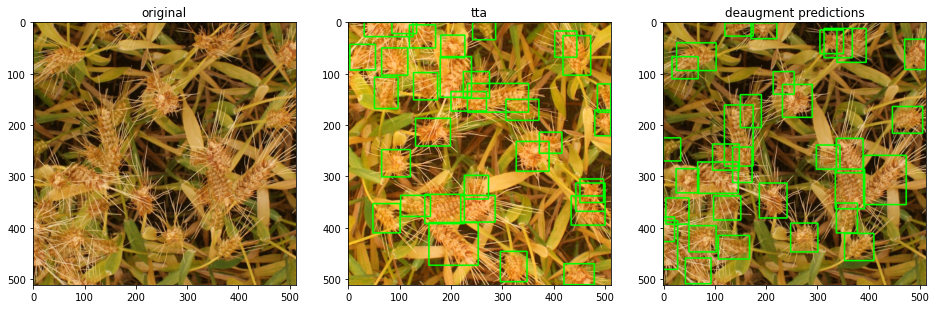

In [5]:
transform = TTACompose([
    TTARotate90(),
    TTAVerticalFlip(),
    TTAHorizontalFlip(),
    TTASaturation()
])

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

image, image_id, _ = test_dataset[5]
numpy_image = image.permute(1,2,0).cpu().numpy().copy()

ax[0].imshow(numpy_image);
ax[0].set_title('original')

tta_image = transform.augment(image)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()

det = net(tta_image.unsqueeze(0).float().cuda(), torch.tensor([1]).float().cuda())
boxes, scores = process_det(0, det)

for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

ax[1].imshow(tta_image_numpy);
ax[1].set_title('tta')
boxes = transform.deaugment_boxes(boxes)

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax[2].imshow(numpy_image);
ax[2].set_title('deaugment predictions');

### Generating all possible combinations of transforms

In [5]:
from itertools import product
tta_transforms = []

for rotate in (TTARotate90(), TTARotate180()):
    combinations = product(
        [TTAHorizontalFlip(), None],
        [TTAVerticalFlip(), None],
        [rotate, None],
    )

    for tta_combination in combinations:
        tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))
print("Number of TTA Compositions:", len(tta_transforms))

Number of TTA Compositions: 16


In [29]:
results = []
images_arr = []

for images, image_id in data_loader:
    print(image_id)
    predictions = make_tta_predictions(images, tta_transforms, net)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.round().astype(np.int32).clip(min=0, max=511)
        results.append(boxes)
        images_arr.append(image.permute(1,2,0).cpu().numpy())

('2fd875eaa.jpg', '51b3e36ab.jpg')
('51f1be19e.jpg', '53f253011.jpg')
('348a992bb.jpg', '796707dd7.jpg')
('aac893a91.jpg', 'cb8d261a3.jpg')
('cc3532ff6.jpg', 'f5a1f0358.jpg')


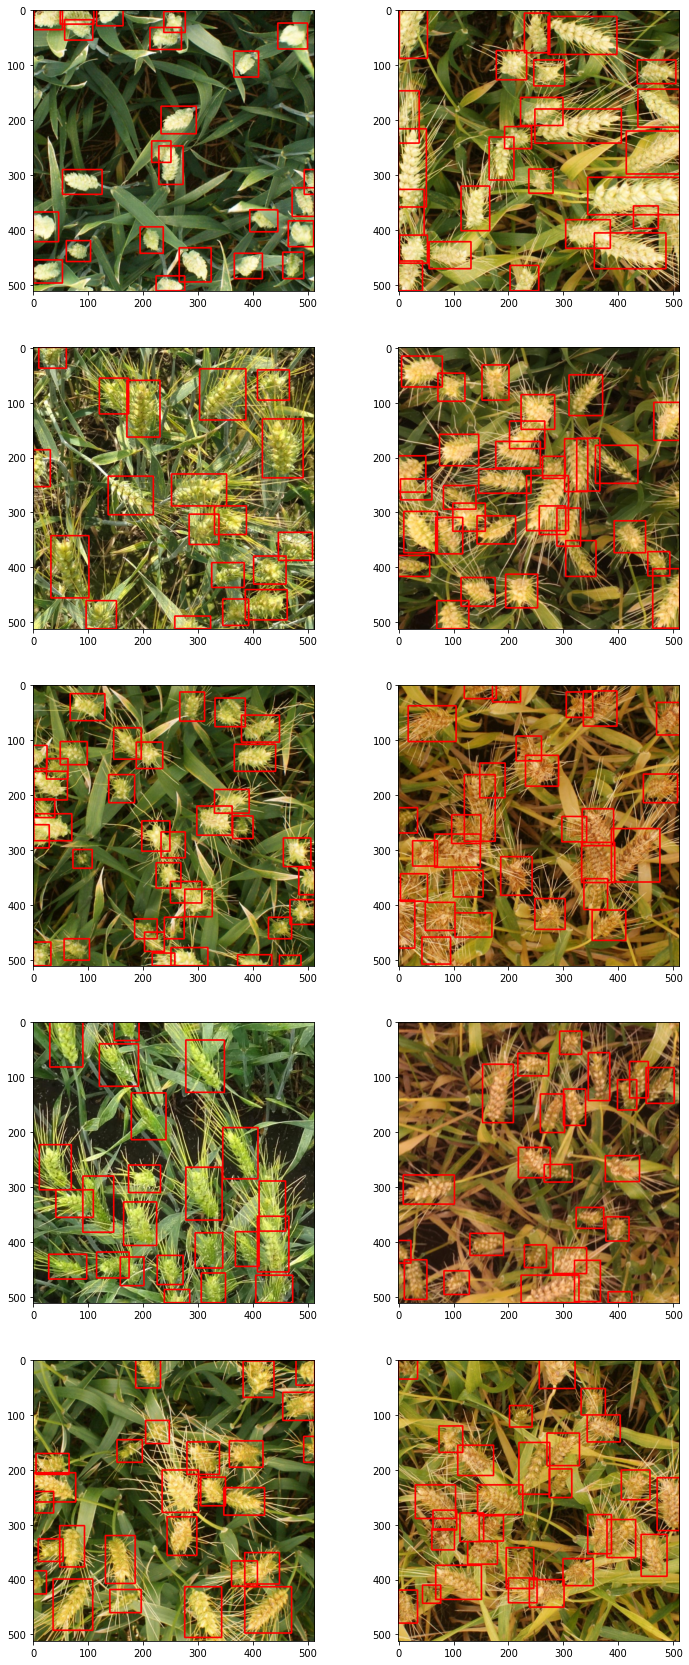

In [31]:
# Plot images and predicted bounding boxes
fig=plt.figure(figsize=(12, 30))

for i in range(10):
    fig.add_subplot(5, 2, i + 1)
    image = images_arr[i]
    for box in results[i]:
        cv2.rectangle(image, (box[0], box[1]), (box[2],  box[3]), (1, 0, 0), 2)
    plt.imshow(image)
plt.show()